In [1]:
import libspn as spn
import tensorflow as tf
import numpy as np

# Params

### Data

In [2]:
# Number of values of each variable
num_vals = 10 # 20  

# Number of samples in dataset
num_samples = 1000

# Batch size
batch_size = 1000

# Num epochs
num_epochs = 30

batches_per_epoch = num_samples/batch_size
print(batches_per_epoch)
if int(batches_per_epoch) != batches_per_epoch:
    raise Exception
batches_per_epoch=int(batches_per_epoch)

1.0


### Structure

In [3]:
# Type of input distributions for dense generator
input_dist = spn.DenseSPNGenerator.InputDist.MIXTURE

# Number of input mixtures for dense generator
num_input_mixtures = 10 # 10?

### Learning

In [4]:
# Additive smoothing during learning
additive_smoothing=0
min_additive_smoothing=0
smoothing_decay=0.2
initial_accum_value = 100

# Weight initialization
# weight_init_value = 1
weight_init_value = spn.ValueType.RANDOM_UNIFORM(0, 1)

# Type of inference during upward pass of learning
value_inference_type = spn.InferenceType.MARGINAL

# Add random values before max
add_random=None

use_unweighted=True

# Generate Training Set

In [5]:
components = [spn.GaussianMixtureDataset.Component(0.1, [1,1], [[1,0],[0,1]]),
              spn.GaussianMixtureDataset.Component(0.2, [1,4], [[1,0.4],[0.8,1]]),
              spn.GaussianMixtureDataset.Component(0.1, [1,8], [[1,0],[0,1]]),
              spn.GaussianMixtureDataset.Component(0.1, [3,4], [[0.5,0],[0,0.7]]),
              spn.GaussianMixtureDataset.Component(0.1, [3,8], [[1,0],[0,1]]),
              spn.GaussianMixtureDataset.Component(0.1, [5,4], [[1,0],[0,1]]),
              spn.GaussianMixtureDataset.Component(0.3, [5,1], [[1,0.5],[0.5,1]])]

train_set = spn.GaussianMixtureDataset(components=components,
                                     num_samples=num_samples,
                                     num_epochs=num_epochs,
                                     batch_size=batch_size,
                                     shuffle=True,
                                     num_threads=1,
                                     allow_smaller_final_batch=False,
                                     num_vals=num_vals)

In [6]:
train_samples, labels, true_likelihoods = train_set.get_data()

# Generate SPN Structure

In [7]:
ivs = spn.IVs(num_vars=2, num_vals=num_vals)
dense_gen = spn.DenseSPNGenerator(num_decomps=1, num_subsets=2, num_mixtures=1, 
                                  input_dist=input_dist, 
                                  num_input_mixtures=num_input_mixtures)
root = dense_gen.generate(ivs)
spn.generate_weights(root, init_value=weight_init_value)

In [8]:
# spn.display_spn_graph(root)

# Add Learning Ops

In [9]:
ivs.attach_feed(train_samples)
additive_smoothing_var = tf.Variable(additive_smoothing, dtype=spn.conf.dtype)
learning = spn.EMLearning(root, log=True, value_inference_type = value_inference_type,
                          additive_smoothing=additive_smoothing_var, add_random=add_random,
                         initial_accum_value=initial_accum_value, use_unweighted=use_unweighted)
init_weights = spn.initialize_weights(root)
reset_accumulators = learning.reset_accumulators()
accumulate_updates = learning.accumulate_updates()
update_spn = learning.update_spn()
train_likelihood=learning.value.values[root]
avg_train_likelihood = tf.reduce_mean(train_likelihood)

In [10]:
# spn.display_tf_graph()

# Generate Test Set

In [11]:
test_set = spn.IntGridDataset(num_dims=2,
                              num_vals=num_vals,
                              num_epochs=1,
                              batch_size=1000,
                              shuffle=False,
                              num_threads=1,
                              allow_smaller_final_batch=True)

In [12]:
test_samples = test_set.get_data()

# Add Testing Ops

In [13]:
ivs.attach_feed(test_samples)

In [14]:
test_likelihoods = root.get_log_value(inference_type=spn.InferenceType.MARGINAL)

In [15]:
# spn.display_tf_graph()

# Run

In [16]:
with spn.session() as (sess, run):
    sess.run(additive_smoothing_var.initializer)
    sess.run(init_weights)
    sess.run(reset_accumulators)
      
    # Run training
    epoch=1
    epoch_done=0
    epoch_batch=0
    try:
        while run():
            # Calculcate epoch and batch
            epoch_batch+=1
            if epoch_batch>batches_per_epoch:
                epoch_batch=1
                epoch+=1
            print("Epoch: %s Batch: %s" % (epoch, epoch_batch))
            # Every epoch, including first
            if epoch_done != epoch:
                epoch_done = epoch
                # Save SPN
                saver=spn.JSONSaver("/home/czikus/model_%s.spn" % (epoch-1), pretty=True)
                saver.save(root)
                # Reset/init accumulators
                # sess.run(reset_accumulators)
                # Adjust additive smoothing
                ads=max(np.exp(-(epoch-1)*smoothing_decay)*additive_smoothing, min_additive_smoothing)
                sess.run(additive_smoothing_var.assign(ads))
                print("Smoothing: ", sess.run(additive_smoothing_var))
                print("Accumulators RESET!")
            # Run accumulate_updates
            train_samples_arr, labels_arr, train_likelihoods_arr, avg_train_likelihood_val, \
            true_likelihoods_arr, _, \
            root_accum_arr, root_weights = \
                sess.run([train_samples, labels, 
                          train_likelihood, avg_train_likelihood,
                          true_likelihoods,
                          accumulate_updates,
                          # Testing
                          learning.root_accum(), root.weights.node.variable
                         ])
            # Print avg likelihood of this batch data on previous batch weights
            print("Avg likelihood (this batch data on previous weights): %s" % (avg_train_likelihood_val))

            # ----------------------------
            # TEST STUFF
            # - accumulator for root
            # print("This batch data:", train_samples_arr)
            print("This batch accum:", root_accum_arr)
            print("Preious batch weights:", root_weights)
            
            # ----------------------------

            # Update weights
            sess.run(update_spn)
            
    except tf.errors.OutOfRangeError:
        print("TRAINING DONE!")
    
    # Run testing
    try:
        while run():
            test_samples_arr, test_likelihoods_arr = sess.run([test_samples, test_likelihoods])
#            spn.plot_2d(test_samples_arr[:, 0], test_samples_arr[:, 1], probs=likelihoods_arr.ravel(), jitter=False)
    except tf.errors.OutOfRangeError:
        print("TESTING DONE!")


Epoch: 1 Batch: 1
Smoothing:  0.0
Accumulators RESET!
Avg likelihood (this batch data on previous weights): -4.64761
This batch accum: [ 134.  100.  100.  100.  135.  162.  100.  100.  100.  129.  100.  100.
  100.  100.  101.  101.  100.  100.  100.  102.  100.  100.  100.  100.
  100.  100.  100.  100.  100.  100.  114.  100.  100.  100.  105.  125.
  100.  100.  100.  123.  132.  100.  100.  100.  156.  148.  100.  100.
  103.  137.  114.  100.  100.  100.  115.  109.  100.  100.  102.  128.
  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  168.  100.
  100.  100.  141.  111.  100.  100.  107.  133.  179.  100.  100.  100.
  135.  115.  100.  100.  108.  152.  157.  100.  100.  100.  137.  120.
  100.  100.  103.  159.]
Preious batch weights: [  2.04154607e-02   1.96661912e-02   2.64695962e-03   1.38029214e-02
   3.78233660e-03   8.81714001e-03   9.48653207e-04   1.68815926e-02
   1.73226204e-02   4.35651699e-03   1.86697801e-03   5.23599610e-03
   1.89155582e-02   1.166

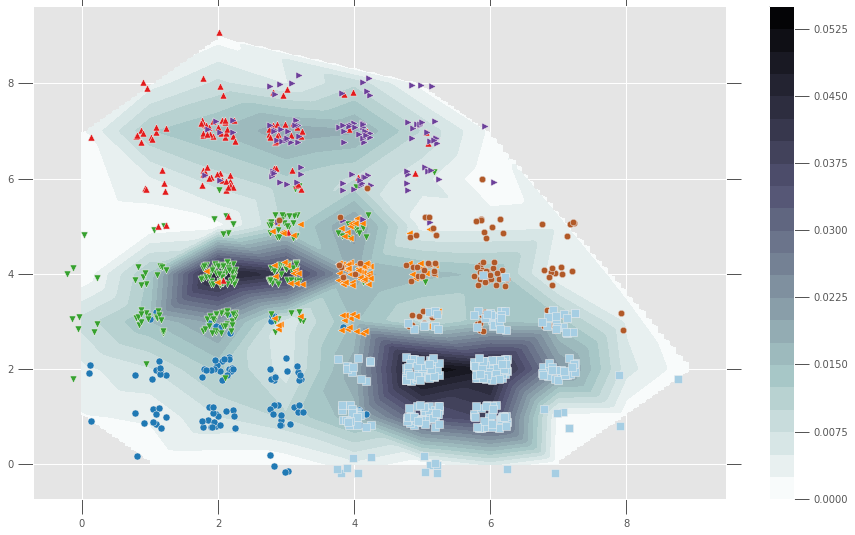

In [17]:
spn.plot_2d(train_samples_arr[:, 0], train_samples_arr[:, 1], labels=labels_arr[:, 0], probs=true_likelihoods_arr)

In [18]:
# spn.plot_2d(train_samples_arr[:, 0], train_samples_arr[:, 1], labels=labels_arr[:, 0],
#             probs=(np.exp(train_likelihoods_arr.ravel())), jitter=True)

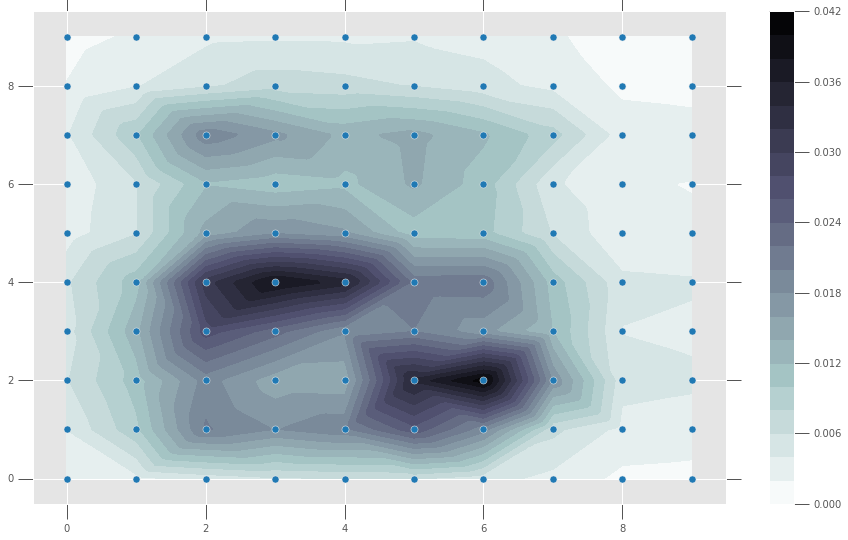

In [19]:
spn.plot_2d(test_samples_arr[:, 0], test_samples_arr[:, 1], 
            probs=(np.exp(test_likelihoods_arr.ravel())), jitter=False)

In [20]:
# for s, l in zip(test_samples_arr, likelihoods_arr):
#    print(s.tolist(), l.tolist())

# Scratch

In [21]:
local_vars=tf.local_variables()

In [22]:
local_vars[0].name

'Dataset/input_producer/input_producer/fraction_of_32_full/limit_epochs/epochs:0'

In [23]:
local_vars[1].name

'Dataset_1/input_producer/input_producer/fraction_of_32_full/limit_epochs/epochs:0'